# **Lab 3(b)**
# Convolution Neural Networks


---


Total Points: **75**

Tentative Weightage : **3%**

Submission Deadline :  **25th March 2021, 23:59 hours**

Link to the dataset : https://drive.google.com/file/d/14HjM98X9T2LIw7L5Io6kq0uRc9GFN93z/view?usp=sharing

---



General Instructions:

---



1. You have to do this lab individually
2. You may use **sklearn, seaborn, matplotlib, pandas, Tensorflow 2.x**
3. All the code should be submitted in the form of a single Jupyter notebook itself.
4. Points for each sub-section are mentioned in the appropriate question.
5. Make sure to begin early as a few experiments may consume more time to run.
6. You can use Google colab to run a jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) (https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
7. The lab must be submitted on Google classroom. The code as well as the accompanying observations should be made part of the python notebook.
8. **Code Readability** is very important. Modularize your code by making use of classes, functions that can be flexibly reused wherever necessary. Also use self explanatory variable names and add comments to describe your approach wherever necessary. You may add additional code or text blocks as necessary.
9. You are expected to submit your **inferences** (preferably in a text block) and not just an error free code.
10. Students are expected to follow the **honor code** of the class.
11. In case of any queries regarding Lab 3, please mail 2019aim1003@iitrpr.ac.in


---

### A long time ago, in a galaxy far far away....

Rey is a warrior who wants to reach her mentor, Luke Skywalker, to complete her training. No one has seen or communicated Skywalker, who has moved to someplace in outer planetary systems for ages. But Rey is fortunate enough to find a document that can help her to reach the destination. However, she is not familiar with the document's script (which happens to be Latin). Also, it is challenging to segment characters in a handwritten script. She can use her droid BB-8 for recognising words. There are two known representations for such words known to BB-8: **Alpha representation**( using alphabets) and **Omega representation**(using shapes). Since BB-8 is an astromech droid, he can use only one of them due to memory constraints.  Rey reaches out to you for help, and you (being an expert in script recognition and convolution neural networks) agree to help her. You are supposed to carry out experiments in the following section to determine which representation could help her.

*May the force be with you!!*

---

# Task: Word Recognition

You have to train a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*For this assignment, you are supposed to use levels 2-5. 
This makes the length of final Alpha vector to be (2+3+4+5) * 26 = 364*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of 11 primitve shapes present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

*For this assignment, you are supposed to use levels 1-5. 
This makes the length of final Omega vector to be (1+2+3+4+5) * 11 = 165*

---

**Note**: For both representations, while splitting, in case of unequal lengths of segments, segments at the end should be of more length e.g. Level 3 split of "omega" = {o,me,ga} and "play" = {p,l,ay}. Also, for a smaller words like "ok" level 3 split = {$\epsilon$,o,k} where $\epsilon$ = empty string. 

---

Your final goal of this assignment is to detemine which representation will be more helpful for word recognition. 



In [ ]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import statistics
import random


# If using Google Colab, use the following package to display the image
# If running on your local system, cv2.imshow shall work fine
# If running on your local system please comment the line below
from google.colab.patches import cv2_imshow

In [ ]:
IMG_HEIGHT = 50
IMG_WIDTH = 250

# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [ ]:

from google.colab import drive
drive.mount('/content/MyDrive', force_remount = True)

Mounted at /content/MyDrive


In [ ]:
#Add the paths for train, validation and test directories

train_dir_path="/content/MyDrive/MyDrive/CS503-ML/WR-Dataset/Train"
validation_dir_path="/content/MyDrive/MyDrive/CS503-ML/WR-Dataset/Validation"
test_dir_path="/content/MyDrive/MyDrive/CS503-ML/WR-Dataset/Test"

# Visualizing sample images

Prepare an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, Mention the number of word classes present in each of the three sets.

----

**(1+1+1) points**

---

In [ ]:
# Insert code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))


def get_dataframe(folder_name):
    dir_list = os.listdir(folder_name)
    print(dir_list)
    list_ = []

    for image in dir_list:
      label = image.split('_')[0]
      list_.append([image, label])
    
    df = pd.DataFrame(list_, columns =['Image', 'Label'])
    return df


# display the dataframes

train_df = get_dataframe(train_dir_path)
val_df = get_dataframe(validation_dir_path)
test_df = get_dataframe(test_dir_path)

display(train_df)
display(val_df)
display(test_df)




['no_0.png', 'no_1.png', 'no_3.png', 'no_4.png', 'no_6.png', 'not_0.png', 'not_1.png', 'not_2.png', 'not_3.png', 'not_4.png', 'not_5.png', 'now_0.png', 'now_2.png', 'now_4.png', 'now_5.png', 'now_6.png', 'now_7.png', 'number_0.png', 'number_1.png', 'number_3.png', 'number_5.png', 'number_6.png', 'number_7.png', 'o_0.png', 'o_2.png', 'o_3.png', 'o_4.png', 'o_5.png', 'o_6.png', 'of_0.png', 'of_1.png', 'of_2.png', 'of_3.png', 'of_4.png', 'of_5.png', 'of_6.png', 'of_7.png', 'off_1.png', 'off_2.png', 'off_3.png', 'off_4.png', 'off_5.png', 'off_6.png', 'off_7.png', 'office_0.png', 'office_1.png', 'office_2.png', 'office_3.png', 'office_5.png', 'office_6.png', 'office_7.png', 'on_0.png', 'on_1.png', 'on_2.png', 'on_5.png', 'on_6.png', 'one_0.png', 'one_1.png', 'one_2.png', 'one_3.png', 'one_4.png', 'one_5.png', 'one_6.png', 'one_7.png', 'online_1.png', 'online_2.png', 'online_3.png', 'online_4.png', 'online_5.png', 'online_7.png', 'only_0.png', 'only_1.png', 'only_2.png', 'only_4.png', 'only_

,Image,Label
0,no_0.png,no
1,no_1.png,no
2,no_3.png,no
3,no_4.png,no
4,no_6.png,no
...,...,...
2047,am_5.png,am
2048,am_7.png,am
2049,an_0.png,an
2050,an_1.png,an


,Image,Label
0,a_3.png,a
1,about_3.png,about
2,add_2.png,add
3,address_5.png,address
4,address_7.png,address
...,...,...
103,user_2.png,user
104,very_5.png,very
105,way_6.png,way
106,website_1.png,website


,Image,Label
0,about_2.png,about
1,address_0.png,address
2,address_2.png,address
3,address_4.png,address
4,after_6.png,after
...,...,...
395,work_7.png,work
396,x_5.png,x
397,year_3.png,year
398,years_5.png,years


In [ ]:


def visualise_image(path , df):
  # reading the image
  file = df["Image"].tolist()
  labels = df["Label"].tolist()
  # print(file)
  fig = plt.figure(figsize=(30, 30))
  rows = 1
  columns = 5
  for i in range(0, len(file)):
    testImage = cv2.imread(path +'/'+  file[i])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(testImage)
    plt.title(labels[i])



Visualise Images from Train set
Number of word classes present in Train set
2052


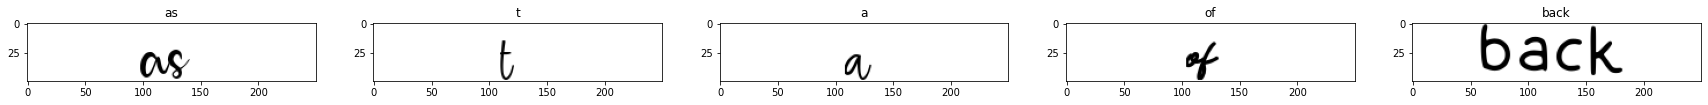

In [ ]:
# Visualise images from the train set
print("Visualise Images from Train set")
visualise_image(train_dir_path , train_df.sample(5) )

print("Number of word classes present in Train set")
print(len(list(dict.fromkeys(train_df["Image"].tolist())  )))

Visualise images from the validation set

 Number of word classes present in validation set
108


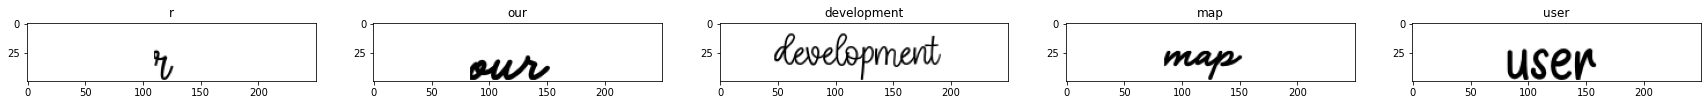

In [ ]:
# Visualise images from the validation set
print("Visualise images from the validation set")
visualise_image(validation_dir_path , val_df.sample(5) )


print("\n Number of word classes present in validation set")

print(len(list(dict.fromkeys(val_df["Image"].tolist())  )))

Visualise images from the test set

 Number of word classes present in test set
400


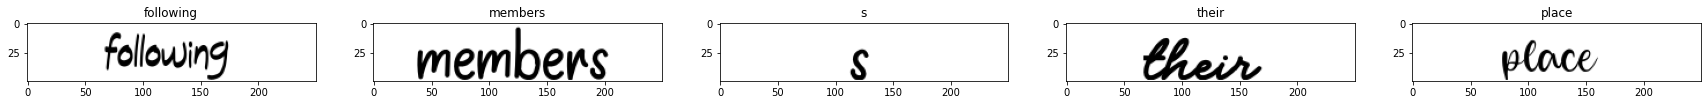

In [ ]:
# Visualise images from the test set
print("Visualise images from the test set")
visualise_image(test_dir_path , test_df.sample(5) )

print("\n Number of word classes present in test set")

print(len(list(dict.fromkeys(test_df["Image"].tolist())  )))

Now, you will have to write modules that can give you vector representations for the input words.

---

**(3 + 3 points)**

---

In [ ]:
def get_Omega_vector(word):
  #Insert the code for a function that returns Omega representation of the input word
  #Hint: For computing count of segments, you can add count of shapes for individual characters (already provided in Alphabet.csv file)

  char_list = list(word.lower())
  df = pd.read_csv("/content/MyDrive/MyDrive/CS503-ML/WR-Dataset/Alphabet.csv" , header=None ,index_col=0)
  # display(df)
  # print(char_list)
  vector = []
  for i in range(1,6):
    l = np.array_split( char_list, i)

    for split_word in l:
      shape_vec = [0,0,0,0,0,0,0,0,0,0,0]
      for ch in split_word:
        data  = df.loc[ch]
        data = data.tolist()
        shape_vec = [data[i] + shape_vec[i] for i in range(len(shape_vec))]

      # print(shape_vec)
      vector+= shape_vec

  
  return np.array(vector)



In [ ]:
def get_Alpha_vector(word):
  #Insert the code for a function that returns Alpha representation of the input word 
  m ={
      'a':0,
      'b':1,
      'c':2,
      'd':3,
      'e':4,
      'f':5,
      'g':6,
      'h':7,
      'i':8,
      'j':9,
      'k':10,
      'l':11,
      'm':12,
      'n':13,
      'o':14,
      'p':15,
      'q':16,
      'r':17,
      's':18,
      't':19,
      'u':20,
      'v':21,
      'w':22,
      'x':23,
      'y':24,
      'z':25,
      
  }
  char_list = list(word.lower())
  # display(df)
  # print(char_list)
  vector = []
  for i in range(2,6):
    l = np.array_split( char_list, i)
    for split_word in l:
      vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

      for ch in split_word:
        vec[m[ch]] = 1
      # print(vec)
      vector+= vec

  
  return np.array(vector)

  


To test the above modules, try printing Omega and Alpha vectors for your first name.

In [ ]:
name ="Abhishek"

print("Omega vector:",get_Omega_vector(name) )

print("Alphavector:",get_Alpha_vector(name))

Omega vector: [4 0 3 0 2 0 2 6 1 1 1 2 0 1 0 1 0 2 4 0 0 0 2 0 2 0 1 0 0 2 1 1 1 2 0 1 0
 1 0 2 3 0 0 0 1 0 1 0 1 0 0 2 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 2 2
 0 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1
 0 1 0 1 0 2 2 0 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0]
Alphavector: [1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Alpha model.

---

**(3 points)**

---

In [ ]:
#Insert the code for function that returns a model which will predict Alpharepresentation

def Alpha_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Layers


    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3, 3),padding='same', activation="relu") )

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same',strides= 2))

    model.add(tf.keras.layers.Convolution2D(128, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(128,kernel_size= (3, 3),padding='same', activation="relu"))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same',strides= 2))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))
    
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(364,activation='sigmoid'))
    
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    opt = tf.keras.optimizers.Adam(learning_rate= learning_rate)
    binary_loss = tf.keras.losses.BinaryCrossentropy()
    sim_metrics = [tf.keras.metrics.CosineSimilarity()]
    
    # Compiling the model
    model.compile(optimizer=opt, loss=binary_loss, metrics=sim_metrics)
    # model.summary()
    
    return model
    

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Omega model.

---

**(3 points)**

---

In [ ]:
#Insert the code for function that returns a model which will predict Omega representation

def Omega_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Layers
    

    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3, 3),padding='same', activation="relu") )

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same',strides= 2))

    model.add(tf.keras.layers.Convolution2D(128, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(128,kernel_size= (3, 3),padding='same', activation="relu"))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same',strides= 2))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(256, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))
    model.add(tf.keras.layers.Convolution2D(512, kernel_size=(3, 3),padding='same', activation="relu"))

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(165,activation='relu'))
    
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    opt = tf.keras.optimizers.Adam(learning_rate= learning_rate)
    sim_metrics = [tf.keras.metrics.CosineSimilarity(),tf.keras.metrics.MeanSquaredError()]
    
    # Compiling the model
    model.compile(optimizer=opt, loss='mse', metrics=sim_metrics)
    
    return model
    

Why did we use BCE as loss function and sigmoid as activation for final layer in Alpha model, while MSE and ReLu for Omega model? 

----

**2 points**

---

>In the Alpha Representation, the vector we get has got only two values either 0 or 1 (ie, binary) , therefore it is wise to choose Binary Cross Entropy (BCE) for the Alpha model. The output we get from sigmoid  is [0,1], for binary classification we check if output >0.5 then class 1, else 0. This clearly follows our concept of using binary cross entropy as the output is only two values that is binary.

>In the Omega Representation, the vectors values are >=0 , So using a BCE is not a good idea. ReLu gives the output as a integer >=0 and this will be better for Omega Model and so choosing the Mean Squared Error as a loss function would make sense.



## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.

----

**1 point**

---

In [ ]:
#Insert code to print seen word classes 

seen_list = train_df["Label"].tolist()
seen_list = list(dict.fromkeys(seen_list))
print("\nThis is the seen Words")

print(seen_list)

#Insert code to print unseen word classes from test set

unseen_list = test_df["Label"].tolist()
unseen_list = list(dict.fromkeys(unseen_list))
print("\nThis is the Unseen Words")
print(unseen_list)



This is the seen Words
['no', 'not', 'now', 'number', 'o', 'of', 'off', 'office', 'on', 'one', 'online', 'only', 'open', 'or', 'order', 'other', 'our', 'out', 'over', 'own', 'p', 'page', 'pages', 'part', 'people', 'phone', 'please', 'pm', 'policy', 'post', 'posted', 'price', 'prices', 'privacy', 'product', 'products', 'program', 'project', 'public', 'r', 're', 'read', 'real', 'related', 'report', 'research', 'reserved', 'results', 'review', 'reviews', 'right', 'rights', 's', 'said', 'same', 'school', 'search', 'section', 'security', 'see', 'send', 'service', 'services', 'set', 'she', 'shipping', 'should', 'show', 'sign', 'site', 'so', 'software', 'some', 'south', 'special', 'sports', 'state', 'states', 'store', 'subject', 'such', 'support', 'system', 't', 'take', 'technology', 'terms', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'time', 'to', 'today', 'top', 'travel', 'two', 'type', 'uk', 'under', 'united', 'university', 'up', 

In [ ]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 

----

**1 point**

---

In [ ]:

#Insert the code for loading train and validation set images and their corresponding labels 

# Here I am computing the omega vectors for each sample in train set & val set
train_df["omega"] = train_df["Label"].apply(get_Omega_vector) 
val_df["omega"] = val_df["Label"].apply(get_Omega_vector) 

# Here I am computing the omega vectors for each sample in train set & val set

train_df["alpha"] = train_df["Label"].apply(get_Alpha_vector) 
val_df["alpha"] = val_df["Label"].apply(get_Alpha_vector) 


print(train_df["omega"])
print("**************************************************")
print(train_df["alpha"])

# This data is used in further cells

0       [0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
2047    [0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 1, 0, ...
2048    [0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 1, 0, ...
2049    [0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, ...
2050    [0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, ...
2051    [0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, ...
Name: omega, Length: 2052, dtype: object
**************************************************
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# This function is for getting the images as a numpy array
  
def getImageArray(path, img):
    
  # load the image via load_img function
  img = tf.keras.preprocessing.image.load_img(os.path.join(path,img)) 
  # convert the given image into  numpy array
  return tf.keras.preprocessing.image.img_to_array(img)







In [ ]:
# loading the images as numpy arrays for training prupose
img_list = []
for img in train_df["Image"]:
  img_list.append(getImageArray(train_dir_path , img))

train_X = np.array(img_list)

print(train_X.shape)
print(train_X)

(2052, 50, 250, 3)
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
  

In [ ]:
# loading the images from  validation set as numpy arrays
img_list = []

for img in val_df["Image"]:
  img_list.append(getImageArray(validation_dir_path , img))

val_X = np.array(img_list)

print(val_X.shape)


(108, 50, 250, 3)


In [ ]:
# loading the omega vectors as numpy arrays for fit()

train_omega_y = np.array(train_df["omega"].tolist())
val_omega_y = np.array(val_df["omega"].tolist())


In [ ]:
print(train_omega_y.shape)
print(val_omega_y.shape)


#  Now the data has been loaded successfully in the varaibles -

# train_X - image data from train set
# train_omega_y - omega vectors from training labels
# val_X - image data from validation set
# val_omega_y - omega vectors from validation labels

(2052, 165)
(108, 165)


Now find the best LR for the Omega model.

----

**4 points**

---

In [ ]:
def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        
        model = Omega_model(l_rate)
        model.summary()
        # Insert your code here to train the model using the training set and validate using the validation set
        
        H = model.fit(
                x = train_X , y = train_omega_y ,     batch_size= BATCH_SIZE , epochs=NUM_EPOCHS, verbose=1,callbacks = None ,
                validation_data= (val_X , val_omega_y)
                )    
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        similarity = statistics.mean(H.history['val_cosine_similarity'])
        avg_val_similarity.append(similarity)

    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    best_lr =  learning_rates[avg_val_similarity.index(max(avg_val_similarity))]

    return best_lr  


# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

hi
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 250, 64)       1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 250, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 125, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 125, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 125, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 63, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 63, 256)     

In [ ]:
print(best_Omega_lr)

0.0001


# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 

---

**1 Point**

---

In [ ]:
#Insert the code for loading train and validation set images and their corresponding labels (1 point)

#since the images for train & validation set has been loaded earlier in train_X & val_X respectively I am not loading it here again

# loading the alpha vectors as numpy arrays

train_alpha_y = np.array(train_df["alpha"].tolist())
val_alpha_y = np.array(val_df["alpha"].tolist())

print(train_alpha_y.shape)
print(val_alpha_y.shape)

(2052, 364)
(108, 364)


Now find the best LR for the Alpha model.

----

**4 points**

---

In [ ]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        alpha_model = Alpha_model(l_rate)
      
        # Insert your code here to train the model using the training set and validate using the validation set
        H = alpha_model.fit(
                x = train_X , y = train_alpha_y ,     batch_size= BATCH_SIZE , epochs=NUM_EPOCHS, verbose=1,callbacks = None ,
                validation_data= (val_X , val_alpha_y)
                )
        
        # Insert your code here to find the average validation similarity for this model setting and append it to the maintained list
        similarity = statistics.mean(H.history['val_cosine_similarity'])
        avg_val_similarity.append(similarity)

    # Insert your code here to figure out the learning rate which gives the highest average validation similarity. Print the value and return it.
    best_lr =  learning_rates[avg_val_similarity.index(max(avg_val_similarity))]

    return best_lr  


# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()

Epoch 1/30
257/257 [==============================] - 22s 84ms/step - loss: 0.2849 - cosine_similarity: 0.2714 - val_loss: 0.1664 - val_cosine_similarity: 0.2831
Epoch 2/30
257/257 [==============================] - 21s 83ms/step - loss: 0.1726 - cosine_similarity: 0.2945 - val_loss: 0.1664 - val_cosine_similarity: 0.2821
Epoch 3/30
257/257 [==============================] - 21s 83ms/step - loss: 0.1709 - cosine_similarity: 0.2978 - val_loss: 0.1655 - val_cosine_similarity: 0.2871
Epoch 4/30
257/257 [==============================] - 21s 82ms/step - loss: 0.1702 - cosine_similarity: 0.3005 - val_loss: 0.1654 - val_cosine_similarity: 0.2858
Epoch 5/30
257/257 [==============================] - 21s 83ms/step - loss: 0.1693 - cosine_similarity: 0.2978 - val_loss: 0.1648 - val_cosine_similarity: 0.2889
Epoch 6/30
257/257 [==============================] - 21s 83ms/step - loss: 0.1714 - cosine_similarity: 0.3025 - val_loss: 0.1650 - val_cosine_similarity: 0.2915
Epoch 7/30
257/257 [========

In [ ]:
print(best_Alpha_lr)

0.0001


---

Describe the purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping() **[2 Points]**

> This is used when our goal is to minimise the loss during training.For every epoch in the training loop it checks whether the loss is no longer decreasing. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
>The arguments are as follows:
* monitor -
It is the Quantity to be monitored usually 'loss' or 'val_loss'.
* min_delta -
It is the minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* patience -
Number of epochs with no improvement after which training will be stopped.
* verbose -
It is the verbosity mode.
* mode -It can be one of `{"auto", "min", "max"}`. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* baseline -
Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* restore_best_weights - 
Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

2. ReduceLROnPlateau() **[2 Points]**

> Used to reduce learning rate when a metric has stopped improving. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. It has the following arguments ;
* monitor -
quantity to be monitored.
* factor -
factor by which the learning rate will be reduced. new_lr = lr * factor.
* patience -
number of epochs with no improvement after which learning rate will be reduced.
* verbose - verbosibilty mode,
int. 0: quiet, 1: update messages.
* mode - It is 
one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
* min_delta -
threshold for measuring the new optimum, to only focus on significant changes.
* cooldown -
number of epochs to wait before resuming normal operation after lr has been reduced.
* min_lr -
lower bound on the learning rate.



3. CSVLogger() **[2 Points]**

>This Callback that saves the epoch results to a CSV file.Supports all values that can be represented as a string, including 1D iterables such as np.ndarray.
It has the following arguments
* filename -
Filename of the CSV file, e.g. 'log.csv'.
* separator -
String used to separate elements in the CSV file.It can be a comma or anything else.
* append -
It is a Boolean.If True: append if file exists (useful for continuing training) basically it appends instead of overwriting the logs. If False: overwrite existing file.



4. ModelCheckPoint()  **[2 Points]**

> This Callback is used to save the Keras model or model weights at some frequency, so the model or weights can be loaded later to continue the training from the state saved.
Arguments are as follows
* filepath - 
It is the string or PathLike, path to save the model file. filepath can contain named formatting options, which will be filled the value of epoch and keys in logs (passed in on_epoch_end).
* monitor - 
The metric name to monitor. Typically the metrics are set by the Model.compile method. 
* verbose -
verbosity mode, 0 or 1.
* save_best_only -
if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
* mode -
one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity.
* save_weights_only - 
if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
* save_freq -
'epoch' or integer. When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches. If the Model is compiled with steps_per_execution=N, then the saving criteria will be checked every Nth batch. Note that if the saving isn't aligned to epochs, the monitored metric may potentially be less reliable (it could reflect as little as 1 batch, since the metrics get reset every epoch). Defaults to 'epoch'.
* options -
Optional tf.train.CheckpointOptions object if save_weights_only is true or optional tf.saved_model.SaveOptions object if save_weights_only is false.
* **kwargs - 
Additional arguments for backwards compatibility. Possible key is period.



# Model building and training using callbacks

---
Now build and summarize the Omega model as per the best learning rate value determined earlier.

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR determined
model = Omega_model(best_Omega_lr)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 250, 64)       1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 250, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 125, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 125, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 125, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 63, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 63, 256)       2

Now instantiate the four callbacks which you have described above.


---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
e_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# CSVlogger for keeping logs in filename of your choice
csv_logger = tf.keras.callbacks.CSVLogger('omega_training.log', separator=',', append=True)

# ModelCheckpoint that saves the best weights of model after every 10 epochs

omega_checkpoint_filepath = '/checkpoint/omega'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=omega_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    epochs =10,
    save_best_only=True)

# Make a list of all the callbacks

call_backs = [e_stopping , reduce_lr , csv_logger , model_checkpoint_callback]



Now train the model using these callbacks for the loaded training word images.

---

**7 Points**

---

In [ ]:
# Insert code to train with callbacks (2 points)

H = model.fit(
        x = train_X , y = train_omega_y ,     batch_size= BATCH_SIZE , epochs=NUM_EPOCHS, verbose=1,callbacks = call_backs ,
        validation_data= (val_X , val_omega_y)
        )
        






Epoch 1/30
257/257 [==============================] - 78s 177ms/step - loss: 0.3291 - cosine_similarity: 0.6336 - mean_squared_error: 0.3291 - val_loss: 0.2318 - val_cosine_similarity: 0.7303 - val_mean_squared_error: 0.2318
Epoch 2/30
257/257 [==============================] - 44s 170ms/step - loss: 0.2505 - cosine_similarity: 0.7018 - mean_squared_error: 0.2505 - val_loss: 0.2451 - val_cosine_similarity: 0.7340 - val_mean_squared_error: 0.2451
Epoch 3/30
257/257 [==============================] - 44s 170ms/step - loss: 0.2473 - cosine_similarity: 0.7124 - mean_squared_error: 0.2473 - val_loss: 0.2134 - val_cosine_similarity: 0.7376 - val_mean_squared_error: 0.2134
Epoch 4/30
257/257 [==============================] - 44s 169ms/step - loss: 0.2410 - cosine_similarity: 0.7153 - mean_squared_error: 0.2410 - val_loss: 0.2286 - val_cosine_similarity: 0.7419 - val_mean_squared_error: 0.2286
Epoch 5/30
257/257 [==============================] - 43s 168ms/step - loss: 0.2357 - cosine_similar

In [ ]:
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)

df = pd.read_csv("/content/omega_training.log")
display(df)
epochs  = df["epoch"]
training_similarity = df["cosine_similarity"]
val_similarity = df["val_cosine_similarity"]

train_loss = df["loss"]
val_loss = df["val_loss"]

print("Epocs :", epochs)
print("Training Similarity :" , training_similarity)
print("Training Loss :" , train_loss)
print("Validation similarity" , val_similarity)
print("Validation Loss" , val_loss)



,epoch,cosine_similarity,loss,lr,mean_squared_error,val_cosine_similarity,val_loss,val_mean_squared_error
0,0,0.679864,0.289924,0.0001,0.289924,0.730344,0.231845,0.231845
1,1,0.705733,0.253937,0.0001,0.253937,0.733960,0.245137,0.245137
2,2,0.713029,0.242155,0.0001,0.242155,0.737591,0.213375,0.213375
3,3,0.716800,0.241168,0.0001,0.241168,0.741934,0.228624,0.228624
4,4,0.724150,0.233295,0.0001,0.233295,0.750394,0.213038,0.213038
5,5,0.729795,0.227962,0.0001,0.227962,0.753494,0.210464,0.210464
6,6,0.736139,0.222925,0.0001,0.222925,0.768230,0.195796,0.195796
7,7,0.753201,0.209411,0.0001,0.209411,0.793764,0.184138,0.184138
8,8,0.777680,0.190952,0.0001,0.190952,0.795881,0.186025,0.186025
9,9,0.805423,0.173931,0.0001,0.173931,0.827877,0.150779,0.150779


Epocs : 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: epoch, dtype: int64
Training Similarity : 0     0.679864
1     0.705733
2     0.713029
3     0.716800
4     0.724150
5     0.729795
6     0.736139
7     0.753201
8     0.777680
9     0.805423
10    0.825959
11    0.839855
12    0.851853
13    0.860636
14    0.872035
15    0.880927
16    0.889544
17    0.897980
18    0.906486
19    0.916166
20    0.920628
21    0.929831
22    0.936566
23    0.942855
24    0.949159
25    0.953537
26    0.956782
27    0.960712
28    0.963920
29    0.967947
Name: cosine_similarity, dtype: float64
Training Loss : 0     0.289924
1     0.253937
2     0.242155
3     0.241168
4     0.233295
5     0.227962
6     0.222925
7     0.209411
8     0.190952
9     0.173931
10    0.156798
11 

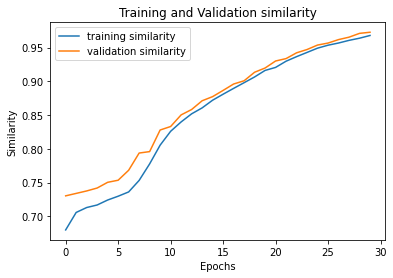

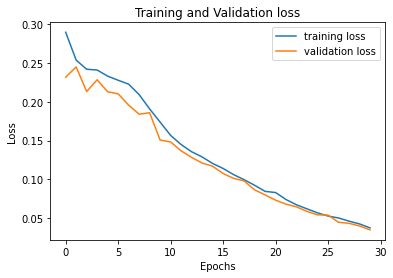

In [ ]:

# Insert your code here to plot Epochs Vs. training and validation similarity (2 points)

plt.plot(epochs, training_similarity, label='training similarity')
plt.plot(epochs, val_similarity,  label='validation similarity')
plt.title('Training and Validation similarity')
plt.xlabel('Epochs')
plt.ylabel('Similarity')
plt.legend()
plt.show()



# Insert your code here to plot Epochs Vs. training and validation loss (2 points)

plt.plot(epochs, train_loss, label='training loss')
plt.plot(epochs, val_loss,  label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Now build and summarize the Alpha model as per the best learning rate value determined earlier. 

---

**1 Point**

---




In [ ]:
# Insert code for building model using the best LR for Alpha model determined
model =  Alpha_model(best_Alpha_lr)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 50, 250, 64)       1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 250, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 125, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 125, 128)      73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 125, 128)      147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 63, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 63, 256)      

Now instantiate the four callbacks for Alpha model.

---

**2 Points**

---

In [ ]:
# EarlyStopping after validation loss has not improved for 5 epochs 
e_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# CSVlogger for keeping logs in filename of your choice
csv_logger = tf.keras.callbacks.CSVLogger('alpha_training.log', separator=',', append=True)

# ModelCheckpoint that saves the best weights of model after every 10 epochs

alpha_checkpoint_filepath = '/checkpoint/alpha'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=alpha_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,

    epochs= 10
    )

# Make a list of all the callbacks

call_backs = [e_stopping , reduce_lr , csv_logger , model_checkpoint_callback]



Now train the model with training data using these callbacks.

---

**7 Points**

---

In [ ]:

# Insert code to train with callbacks (2 points)

H = model.fit(
        x = train_X , y = train_alpha_y ,  batch_size= BATCH_SIZE , epochs=NUM_EPOCHS, verbose=1,callbacks = call_backs ,
        validation_data= (val_X , val_alpha_y)
        )
        




Epoch 1/30
257/257 [==============================] - 45s 169ms/step - loss: 0.2427 - cosine_similarity: 0.2329 - val_loss: 0.1616 - val_cosine_similarity: 0.2804
Epoch 2/30
257/257 [==============================] - 43s 169ms/step - loss: 0.1713 - cosine_similarity: 0.2750 - val_loss: 0.1612 - val_cosine_similarity: 0.2850
Epoch 3/30
257/257 [==============================] - 44s 170ms/step - loss: 0.1675 - cosine_similarity: 0.2864 - val_loss: 0.1592 - val_cosine_similarity: 0.2901
Epoch 4/30
257/257 [==============================] - 44s 169ms/step - loss: 0.1667 - cosine_similarity: 0.2903 - val_loss: 0.1590 - val_cosine_similarity: 0.2903
Epoch 5/30
257/257 [==============================] - 44s 170ms/step - loss: 0.1667 - cosine_similarity: 0.2908 - val_loss: 0.1584 - val_cosine_similarity: 0.2910
Epoch 6/30
257/257 [==============================] - 44s 170ms/step - loss: 0.1638 - cosine_similarity: 0.2972 - val_loss: 0.1586 - val_cosine_similarity: 0.2885
Epoch 7/30
257/257 [==

In [ ]:

# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
alpha_df = pd.read_csv("/content/alpha_training.log")

epochs  = alpha_df["epoch"]
training_similarity = alpha_df["cosine_similarity"]
val_similarity = alpha_df["val_cosine_similarity"]

train_loss = alpha_df["loss"]
val_loss = alpha_df["val_loss"]

print("Epocs :", epochs)
print("Training Similarity :" , training_similarity)
print("Training Loss :" , train_loss)
print("Validation similarity" , val_similarity)
print("Validation Loss" , val_loss)




Epocs : 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: epoch, dtype: int64
Training Similarity : 0     0.254597
1     0.281698
2     0.288569
3     0.291798
4     0.294639
5     0.297650
6     0.297488
7     0.299044
8     0.299818
9     0.304552
10    0.311592
11    0.319966
12    0.333668
13    0.344868
14    0.356228
15    0.378313
16    0.403774
17    0.433169
18    0.459861
19    0.493034
20    0.529520
21    0.568302
22    0.611149
23    0.651629
24    0.705187
25    0.750997
26    0.799874
27    0.835243
28    0.863942
29    0.897164
Name: cosine_similarity, dtype: float64
Training Loss : 0     0.193367
1     0.172062
2     0.168968
3     0.168116
4     0.167138
5     0.166777
6     0.166631
7     0.165819
8     0.165721
9     0.164641
10    0.162471
11 

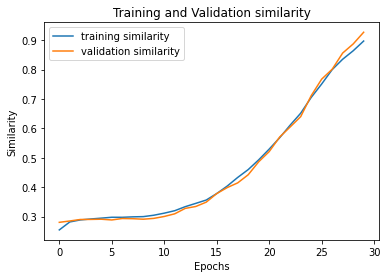

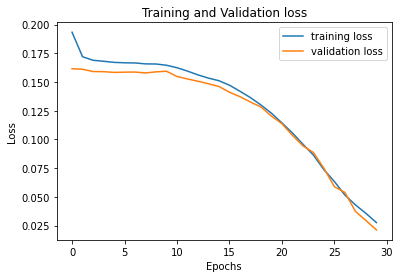

In [ ]:
# Insert your code here to plot Epochs Vs. training and validation similarity (2 points)

plt.plot(epochs, training_similarity, label='training similarity')
plt.plot(epochs, val_similarity,  label='validation similarity')
plt.title('Training and Validation similarity')
plt.xlabel('Epochs')
plt.ylabel('Similarity')
plt.legend()
plt.show()



# Insert your code here to plot Epochs Vs. training and validation loss (2 points)

plt.plot(epochs, train_loss, label='training loss')
plt.plot(epochs, val_loss,  label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).

---

**1 point**

---


In [ ]:
# creating a list of dictionary so that the vectors can be mapped to the words
test_list  = []

for test_label in test_df["Label"]:
  test_list.append({
      "word" : test_label,
      "omega_vector" : get_Omega_vector(test_label),
      "alpha_vector": get_Alpha_vector(test_label)
  })

print(test_list)



[{'word': 'about', 'omega_vector': array([1, 0, 2, 0, 2, 0, 3, 5, 0, 0, 1, 1, 0, 2, 0, 2, 0, 3, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]), 'alpha_vector': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.

---

**1 point**

---

In [ ]:
# Insert code to load test images and its vector labels (1 points)

img_list = []

for img in test_df["Image"]:
  img_list.append(getImageArray(test_dir_path , img))

test_X = np.array(img_list)

print(test_X.shape)

test_y = [x["alpha_vector"] for x in test_list ]
alpha_test_y  = np.array(test_y)




(400, 50, 250, 3)


Now load the saved trained Alpha model from the file and predict the labels

---

**1+3 points**

---

In [ ]:
# Insert code for loading the saved model from file 

alpha_model = Alpha_model(best_Alpha_lr)
alpha_model.load_weights(alpha_checkpoint_filepath)



In [ ]:
# Insert code for predicting word labels of the test set images 

alpha_predictions = alpha_model.predict(test_X ,batch_size= BATCH_SIZE, verbose= 1 )

print(alpha_predictions)


50/50 [==============================] - 3s 60ms/step
[[6.7970747e-01 6.2675399e-01 1.0658211e-02 ... 5.3801155e-06
  6.8644650e-04 6.9786488e-06]
 [9.4628018e-01 3.3421005e-05 2.9811510e-01 ... 1.5329717e-07
  5.0448303e-08 1.1113185e-07]
 [9.4465500e-01 3.2218237e-04 1.7052481e-01 ... 2.4772365e-07
  3.5698022e-08 1.7960906e-07]
 ...
 [3.2411993e-02 5.8781005e-02 1.3284479e-06 ... 1.0520050e-10
  4.9421618e-07 4.4827198e-13]
 [3.2008108e-01 7.6287203e-02 3.4552839e-05 ... 1.6158165e-07
  8.0086014e-05 1.7340680e-08]
 [2.7402823e-03 2.8603124e-02 1.3643731e-06 ... 8.8512460e-13
  9.5648193e-06 2.2603508e-10]]


In [ ]:
# this function computes the cosine similarity of two vectors
def cosine_similarity(a, b):

  dot = np.dot(a, b)
  norma = np.linalg.norm(a)
  normb = np.linalg.norm(b)
  cos = dot / (norma * normb)
  return cos

In [ ]:

actual_words = [x["word"] for x in test_list ]    #this list contains actual test words

# In the below lines of codes I am predicting the words by choosing the words whose simialrity score is the highest
predicted_words =[]
for predicted_vector in alpha_predictions:
  cosine_sim = 0
  p_label = ""
  for idx in test_list:
    cos = cosine_similarity(idx["alpha_vector"] , predicted_vector)
    if cos > cosine_sim:
      cosine_sim = cos
      p_label = idx["word"]
  
  predicted_words.append(p_label)

print("Actual Words ")
print(actual_words)


print("\n Predicted words")
print(predicted_words)

Actual Words 
['about', 'address', 'address', 'address', 'after', 'all', 'also', 'am', 'american', 'american', 'american', 'american', 'american', 'american', 'american', 'american', 'and', 'and', 'any', 'any', 'any', 'are', 'are', 'as', 'at', 'at', 'available', 'b', 'be', 'because', 'been', 'before', 'between', 'black', 'book', 'both', 'business', 'business', 'buy', 'by', 'by', 'c', 'c', 'can', 'car', 'care', 'care', 'care', 'care', 'care', 'care', 'care', 'care', 'center', 'comments', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'copyright', 'county', 'county', 'county', 'county', 'county', 'county', 'county', 'county', 'd', 'data', 'data', 'day', 'day', 'days', 'days', 'design', 'details', 'details', 'details', 'development', 'development', 'development', 'did', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'download', 'download', 'download', 'download', 'download', 'download', 'download', 'download', 'education', 


Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.

---

**2 Points**

---

In [ ]:
print(len(actual_words))

400


In [ ]:
#  Bwlow code separates out the seen & unseen images so that Accuracy can be calculated

seen_images = []
unseen_images = []

l = len(actual_words)

for i in range( 0,l ):
  if actual_words[i] in seen_list:
    seen_images.append( (actual_words[i] , predicted_words[i]) ) #inserting as a tuple of actual & predicted word
  else:
    unseen_images.append( (actual_words[i] , predicted_words[i]) )


print("Seen Images \n" , seen_images)

print("UnSeen Images \n" , unseen_images)


Seen Images 
 [('about', 'about'), ('address', 'address'), ('address', 'address'), ('address', 'address'), ('after', 'after'), ('all', 'all'), ('also', 'also'), ('am', 'am'), ('and', 'and'), ('and', 'and'), ('any', 'any'), ('any', 'any'), ('any', 'any'), ('are', 'are'), ('are', 'are'), ('as', 'as'), ('at', 'at'), ('at', 'at'), ('available', 'available'), ('b', 'b'), ('be', 'we'), ('because', 'because'), ('been', 'been'), ('before', 'before'), ('between', 'between'), ('black', 'black'), ('book', 'book'), ('both', 'both'), ('business', 'business'), ('business', 'business'), ('buy', 'buy'), ('by', 'by'), ('by', 'by'), ('c', 'c'), ('c', 'c'), ('can', 'can'), ('car', 'car'), ('center', 'center'), ('comments', 'comments'), ('copyright', 'copyright'), ('d', 'd'), ('data', 'data'), ('data', 'data'), ('day', 'day'), ('day', 'day'), ('days', 'days'), ('days', 'days'), ('design', 'design'), ('details', 'details'), ('details', 'details'), ('details', 'details'), ('development', 'development'), ('d

In [ ]:
# Function for computing the accuracy
def find_accuracy(l ):
  c = 0
  for x in l:
    if x[0] == x[1]:
      c =c +1
  
  return (c / len(l)) * 100


In [ ]:



# Insert code to compute accuracy of images that belong to seen classes 
seen_acc = find_accuracy(seen_images) 
print("Accuracy on seen Images :" , seen_acc ," %" )


# Insert code to compute accuracy of images that belong to unseen classes 

unseen_acc = find_accuracy(unseen_images) 
print("Accuracy on Unseen Images :" , unseen_acc , " %" )



# Insert code to compute effective accuracy
effective_acc  = statistics.harmonic_mean([ seen_acc , unseen_acc ])

print("Effective Accuracy of Alpha Model : " , effective_acc , " %")


Accuracy on seen Images : 97.91666666666666  %
Accuracy on Unseen Images : 16.25  %
Effective Accuracy of Alpha Model :  27.874087591240873  %


Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.

---

**1 Points**

---

In [ ]:
# Insert code to load test images and its vector labels
# I am not loading the test image as it is already loaded earlier in test_X

y = [x["omega_vector"] for x in test_list ]
omega_test_y  = np.array(y)

print(omega_test_y)


[[1 0 2 ... 0 0 1]
 [2 0 6 ... 0 0 0]
 [2 0 6 ... 0 0 0]
 ...
 [0 1 2 ... 0 0 0]
 [0 1 3 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


Now load the saved trained Omega model from the file and predict the labels

---

**1+3 Points**

---

In [ ]:
# Insert code for loading the saved model from file

omega_model = Omega_model(best_Omega_lr)
omega_model.load_weights(omega_checkpoint_filepath)



In [ ]:
# Insert code for predicting word labels of the test set images

omega_predictions = omega_model.predict(test_X , batch_size= BATCH_SIZE, verbose= 1 )

print(omega_predictions.shape)
print(omega_predictions)

50/50 [==============================] - 3s 60ms/step
(400, 165)
[[1.0958424  0.03327553 2.5440724  ... 0.         0.         1.0162134 ]
 [1.7327391  0.         6.0867763  ... 0.         0.         0.        ]
 [1.7502112  0.         5.9648466  ... 0.         0.         0.        ]
 ...
 [0.         0.8820105  1.6464309  ... 0.         0.         0.        ]
 [0.         0.74008775 2.664907   ... 0.         0.         0.        ]
 [0.         0.89512277 0.97081614 ... 0.         0.         0.        ]]


In [ ]:
actual_words = [x["word"] for x in test_list ]

predicted_words =[]
for predicted_vector in omega_predictions:
  cosine_sim = 0
  p_label = ""
  for idx in test_list:
    cos = cosine_similarity(idx["omega_vector"] , predicted_vector)
    if cos > cosine_sim:
      cosine_sim = cos
      p_label = idx["word"]
  
  predicted_words.append(p_label)

print("Actual Words ")
print(actual_words)


print("\n Predicted words")
print(predicted_words)

Actual Words 
['about', 'address', 'address', 'address', 'after', 'all', 'also', 'am', 'american', 'american', 'american', 'american', 'american', 'american', 'american', 'american', 'and', 'and', 'any', 'any', 'any', 'are', 'are', 'as', 'at', 'at', 'available', 'b', 'be', 'because', 'been', 'before', 'between', 'black', 'book', 'both', 'business', 'business', 'buy', 'by', 'by', 'c', 'c', 'can', 'car', 'care', 'care', 'care', 'care', 'care', 'care', 'care', 'care', 'center', 'comments', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'computer', 'copyright', 'county', 'county', 'county', 'county', 'county', 'county', 'county', 'county', 'd', 'data', 'data', 'day', 'day', 'days', 'days', 'design', 'details', 'details', 'details', 'development', 'development', 'development', 'did', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'download', 'download', 'download', 'download', 'download', 'download', 'download', 'download', 'education', 

Evaluate the performance of the Omega model

---

**2 Points**

---

In [ ]:
seen_images_omega = []
unseen_images_omega = []

l = len(actual_words)

for i in range( 0,l ):
  if actual_words[i] in seen_list:
    seen_images_omega.append( (actual_words[i] , predicted_words[i]) ) #inserting as a tuple of actual & predicted word
  else:
    unseen_images_omega.append( (actual_words[i] , predicted_words[i]) )


print("Seen Images \n" , seen_images_omega)

print("UnSeen Images \n" , unseen_images_omega)

Seen Images 
 [('about', 'about'), ('address', 'address'), ('address', 'address'), ('address', 'address'), ('after', 'after'), ('all', 'all'), ('also', 'address'), ('am', 'am'), ('and', 'and'), ('and', 'and'), ('any', 'any'), ('any', 'any'), ('any', 'any'), ('are', 'are'), ('are', 'are'), ('as', 'as'), ('at', 'at'), ('at', 'at'), ('available', 'available'), ('b', 'b'), ('be', 'be'), ('because', 'because'), ('been', 'been'), ('before', 'before'), ('between', 'between'), ('black', 'black'), ('book', 'book'), ('both', 'both'), ('business', 'business'), ('business', 'business'), ('buy', 'buy'), ('by', 'by'), ('by', 'by'), ('c', 'c'), ('c', 'c'), ('can', 'car'), ('car', 'car'), ('center', 'center'), ('comments', 'comments'), ('copyright', 'copyright'), ('d', 'd'), ('data', 'data'), ('data', 'data'), ('day', 'day'), ('day', 'day'), ('days', 'days'), ('days', 'days'), ('design', 'design'), ('details', 'details'), ('details', 'details'), ('details', 'details'), ('development', 'development'), 

In [ ]:

# Insert code to compute accuracy of images that belong to seen classes 
seen_acc1 = find_accuracy(seen_images_omega) 
print("Accuracy on seen Images :" , seen_acc1 ," %" )


# Insert code to compute accuracy of images that belong to unseen classes 

unseen_acc1 = find_accuracy(unseen_images_omega) 
print("Accuracy on Unseen Images :" , unseen_acc1 , " %" )



# Insert code to compute effective accuracy
effective_acc1  = statistics.harmonic_mean([ seen_acc1 , unseen_acc1 ])

print("Effective Accuracy of Alpha Model : " , effective_acc1 , " %")


Accuracy on seen Images : 95.41666666666667  %
Accuracy on Unseen Images : 38.125  %
Effective Accuracy of Alpha Model :  54.481279251170044  %


# Results
Based on your experimental outcome and your observations, which representation is better, according to you? 

---

**2 Points**

---
It is clear from the Model performance that Omega model is better compared to Alpha model. In Machine learning it is very important to ensure that our ML model performs well on the Unseen Data as that is what our goal. From the results  obtained, both Alpha model & Omega model gives good accuracy on Seen Data but when it comes to Unseen Data ,  Omega model gives more accuracy compared to Alpha model.

So according to me , Omega representation is better.

We have used only words from the test set to find the matching word. How could results be affected if the lexicon had both: train and test words?

---

**2 Points**

---

If the results had both the train and test words then the effective accuracy for both the models will increase as for the seen train words the accuracy is  high. And more the nuimber of words used from the training set more will the effective accuracy. 

This can be seen from the results that I have obtained , the accuracy on seen data is more than or around 95% for both the models. And the in the train set there are more number of samples around 2000 so there number of correct predictions will increase if both train & test set is used. Therby leading to an increase in the overall accuracy.